In [2]:
import pandas as pd

In [3]:
import os
import json
import colorsys
import random
import numpy as np
import cv2
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib import patches
import imageio
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")

In [3]:
!pip3 uninstall keras-nightly -y
!pip3 uninstall tensorflow -y
!pip3 install keras==2.2.5
# force gpu
!pip3 install tensorflow-gpu==1.15.0
!pip3 install h5py==2.10.0
# Input image dtype is bool error MASK_RCNN
!pip3 install -U scikit-image==0.16.2

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
     |████████████████████████████████| 336 kB 5.3 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
     |████████████████████████████████| 411.5 MB 8.5 kB/s 
     |████████████████████████████████| 3.8 MB 36.0 MB/s 
     |████████████████████████████████| 503 kB 44.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=c677ee808d3cdcb80e30d9daf5746217717f47e93507473378c4ab0b4872abd6
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfull

In [4]:
import tensorflow
import keras
import skimage

# Need this old versions for the package to work
print("Tensorflow version", tensorflow.__version__)
print("Keras version", keras.__version__)
print("Image Sckit", skimage.__version__)
assert(tensorflow.__version__ == "1.15.0")
assert(keras.__version__ == "2.2.5")
assert(skimage.__version__ == "0.16.2")

Tensorflow version 1.15.0
Keras version 2.2.5
Image Sckit 0.16.2


Using TensorFlow backend.


In [5]:
tensorflow.test.is_gpu_available()

True

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

GDRIVE_PATH = "/content/gdrive/MyDrive/Project/"

TRAIN_DATA_IMAGES = "Detection_Train_Set/Detection_Train_Set_Img/"
TRAIN_DATA_LABELS = "Detection_Train_Set/Detection_Train_Set_Json/"
TRAIN_DATA_NAMES = os.listdir(GDRIVE_PATH + TRAIN_DATA_IMAGES)
print("Train Data Length", len(TRAIN_DATA_NAMES))
print("First Train Data", TRAIN_DATA_NAMES[0])

#TEST_DATA_IMAGES = "Detection_Test_Set/Detection_Test_Set_Img/"
#TEST_DATA_LABELS = "Detection_Test_Set/Detection_Test_Set_Json/"
#TEST_DATA_NAMES = os.listdir(GDRIVE_PATH + TEST_DATA_IMAGES)
#print("Test Data Length", len(TEST_DATA_NAMES))
#print("First Test Data", TEST_DATA_NAMES[0])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Train Data Length 1559
First Train Data Batch2__Marseille_01frame785.jpg


In [ ]:
!ls /content/gdrive/MyDrive/Case3/

'Case3 - WSM'


## Get Model from Git

In [7]:
!git clone "https://github.com/SriRamGovardhanam/wastedata-Mask_RCNN-multiple-classes.git" || true
!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'wastedata-Mask_RCNN-multiple-classes'...
remote: Enumerating objects: 151, done.
remote: Total 151 (delta 0), reused 0 (delta 0), pack-reused 151
Receiving objects: 100% (151/151), 12.19 MiB | 26.01 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [6]:
# Import local Mask RCNN
import sys
ROOT_DIR = os.path.abspath("./wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/")
sys.path.append(ROOT_DIR)


from mrcnn.config import Config
from mrcnn import model as modellib, utils
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class ChronsiteConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Chronsite"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 # a memory error occurs when IMAGES_PER_GPU is too high

    BACKBONE = "resnet50"

    # Number of classes (including background)
    NUM_CLASSES = 5  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    IMAGE_RESIZE_MODE = "crop"

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 400

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 40

## Utils

In [7]:
def draw_rectangle(mask, bbox):
    """Helper function for rendering."""
    y1, x1, y2, x2 = bbox[0][1], bbox[0][0], bbox[1][1], bbox[1][0]
    contour = [[x1, y1], [x1, y2], [x2, y2], [x2, y1]]
    contour = np.array(contour, dtype=np.int32)
    cv2.drawContours(mask, [contour], -1, (255), -1)
    return mask

def draw_polygon(mask, contour):
    """Helper function for rendering."""
    contour = np.array(contour, dtype=np.int32)
    cv2.drawContours(mask, [contour], -1, (255), -1)
    return mask

def convert_annotations(annotations, image_shape):
    """Convert masks from polygon to binary mask for training."""
    masks = []
    class_names = []
    for obj in annotations["objects"]:
        class_name = obj["classTitle"]
        mask = np.zeros(image_shape, dtype=np.int8)
        if (obj["geometryType"] == "rectangle"):
            mask = draw_rectangle(mask, obj['points']['exterior'])
        elif (obj["geometryType"] == "polygon"):
            mask = draw_polygon(mask, obj['points']['exterior'])
        masks.append(mask)
        class_names.append(class_name)
    masks = np.stack(masks, axis=2)
    return masks, class_names

## Dataset Loader

In [8]:
from mrcnn import utils as mrcnn_utils

class ChronsiteDataset(mrcnn_utils.Dataset):
    def __init__(self, sample_ids, image_path, label_path, verbose=False):
        super().__init__()
        self.sample_ids = sample_ids
        self.filename_for_image_id = []
        self.verbose = verbose
        self.source = "Chronsite"
        self.class_names_preset = np.array(['BG', 'Concrete_pump_hose',
            'Mixer_truck', 'People', 'Vertical_formwork'])
        self.image_path = image_path
        self.label_path = label_path
        
    def _get_id_of_class(self, clabel):
        if clabel not in self.class_names_preset:
            raise Exception(f'Class {clabel} not present in dataset classes: {self.class_names_preset}')
        return np.where(self.class_names_preset == clabel)[0][0]

    def load_image(self, image_id, zero_image=False):
        """ Load the images during training. """
        filename = self.filename_for_image_id[image_id]
        image = cv2.imread(GDRIVE_PATH + self.image_path + filename)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def load_mask(self, image_id):
        """ Load the masks during training."""
        filename = self.filename_for_image_id[image_id]
        with open(GDRIVE_PATH + self.label_path + filename + ".json") as f:
            annotations = json.load(f)
        shape = (annotations['size']['height'], annotations['size']['width'])
        masks, class_names = convert_annotations(annotations, shape)
        class_ids = np.array([self._get_id_of_class(c) for c in class_names], dtype=np.int32)
        return masks, class_ids

    def load_kernel(self) -> None:
        """ Load the metadate before training. """
        self.classes = set()
        for filename in tqdm(self.sample_ids):
            try:
                image_path = GDRIVE_PATH + TRAIN_DATA_IMAGES + filename
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                with open(GDRIVE_PATH + TRAIN_DATA_LABELS + filename + ".json") as f:
                  annotations = json.load(f)
                if (len(annotations["objects"]) == 0):
                    print(f'Skip sample {filename}, no gt_objects')
                    continue
                for obj in annotations["objects"]:
                    self.classes.update({obj["classTitle"]})
                self.add_image(
                  source=self.source,
                  image_id=filename,
                  sub_class_label="ConstructionSite",
                  path=image_path,
                  image_size=image.shape,
                )
                self.filename_for_image_id.append(filename)
            except Exception as e:
                print(f'EXCP: {e} during handling {filename}')
                continue
        for i, c in enumerate(list(self.class_names_preset[1:])):
            self.add_class(self.source, i + 1, c)
        self.prepare()
        return

# Load the Coco finetuned Model

In [9]:
import mrcnn.model as modellib
from mrcnn import visualize

MODEL_DIR = "logs/"
PRE_TRAINED_MODEL_PATH = GDRIVE_PATH + "mask_rcnn_chronsite_0030.h5"

# Split into Training & Tet Set
random.shuffle(TRAIN_DATA_NAMES)
#train_data = TRAIN_DATA_NAMES[:int((len(TRAIN_DATA_NAMES)+1)*.80)] #Remaining 80% to training set
test_data = TRAIN_DATA_NAMES[int((len(TRAIN_DATA_NAMES)+1)*.80):] #Splits 20% data to test set

# Dataset
#dataset_train = ChronsiteDataset(train_data, TRAIN_DATA_IMAGES, TRAIN_DATA_LABELS)
#dataset_train.load_kernel()
dataset_val = ChronsiteDataset(test_data, TRAIN_DATA_IMAGES, TRAIN_DATA_LABELS)
dataset_val.load_kernel()

config = ChronsiteConfig()
config.IMAGE_RESIZE_MODE = "pad64"
config.IMAGE_SHAPE = [1024, 1280, 3]
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)
# Load the pretrained Model we have done [30 epochs in our case trained on COCO]
model.load_weights(PRE_TRAINED_MODEL_PATH, by_name=True)

 43%|████▎     | 133/311 [00:27<00:34,  5.23it/s]

Skip sample Batch2__Roissy_02frame1704.jpg, no gt_objects


 82%|████████▏ | 255/311 [00:53<00:09,  5.62it/s]

Skip sample Batch2__Roissy_02frame1784.jpg, no gt_objects


100%|██████████| 311/311 [01:04<00:00,  4.81it/s]



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








# Overall Precision Recall Curve

## Utils

In [29]:
def get_label_results(result: dict, pred_matches: list, gt_matches: list,
                       gt_class_id: list, image_id: int, IoUs: list):
    """Sort and merge the matched objects between gt and pred."""
    IoUs = np.max(IoUs, axis=1)
    object_matches = []

    # For each image go through all the objects it tries to predict
    for pred_score, pred_match, pred_class_id, IoU in zip(result["scores"], pred_matches, result["class_ids"], IoUs):
        pred_class = pred_class_id
        gt_class = gt_class_id[int(pred_match)] if pred_match > -1 else -1
        object_matches.append({"image_id": image_id,
                               "pred_class": int(pred_class),
                               "gt_class": int(gt_class),
                               "pred_score": pred_score,
                               "highest_mIoU": IoU})
    for gt_match, gt_class in zip(gt_matches, gt_class_id):
        if gt_match == -1:
            object_matches.append({"image_id": image_id,
                                   "pred_class": -1,
                                   "gt_class": int(gt_class),
                                   "pred_score": 0,
                                   "highest_mIoU": 0})
    return object_matches

def get_pr(df):
    """Calculate P/R pairs for a range of confidence_levels"""
    precisions = [0]
    recalls = [1]
    for confidence_level in np.arange(0, 1.0, 0.01):
        tp = len(df[(df.pred_class == df.gt_class) &
                 (df.pred_score >= confidence_level)])
        fn = len(df[((df.pred_class < 0) |
                 (df.pred_score < confidence_level)) &
                 (df.gt_class > -1)])
        fp = len(df[((df.pred_class > -1) &
                 (df.pred_score >= confidence_level)) &
                 (df.gt_class < 0)])
        precisions.append(tp/(tp+fp+1e-5))
        recalls.append(tp/(tp+fn+1e-5))
    precisions.append(1)
    recalls.append(0)
    return precisions, recalls

def get_ap(precisions, recalls):
    """Calculate Average Percision (AP) from Precision-Recall pairs"""
    AP = 0
    for i in range(len(precisions) - 1):
        AP += (recalls[i] - recalls[i+1]) * (precisions[i] + precisions[i+1]) / 2
    return AP

## Image results to pandas
To get specific PR Curves on labels we need to convert the results to panda to parse out correctly

In [27]:
dataset_inference = dataset_val
IoU = 0.50 #the classic .50

label_results = []
for image_id in tqdm(dataset_inference.image_ids):
  original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    modellib.load_image_gt(dataset_inference, config, image_id, use_mini_mask=False)
  results = model.detect([original_image], verbose=0)
  r = results[0]
  gt_matches, pred_matches, overlaps = utils.compute_matches(
      gt_bbox, gt_class_id, gt_mask, r["rois"],
      r["class_ids"], r["scores"], r['masks'], IoU)
  label_results += get_label_results(r, pred_matches, gt_matches, gt_class_id, image_id, overlaps)
df = pd.DataFrame(label_results)

100%|██████████| 309/309 [13:46<00:00,  2.68s/it]


# Plot Precision Recall Curve for each Class

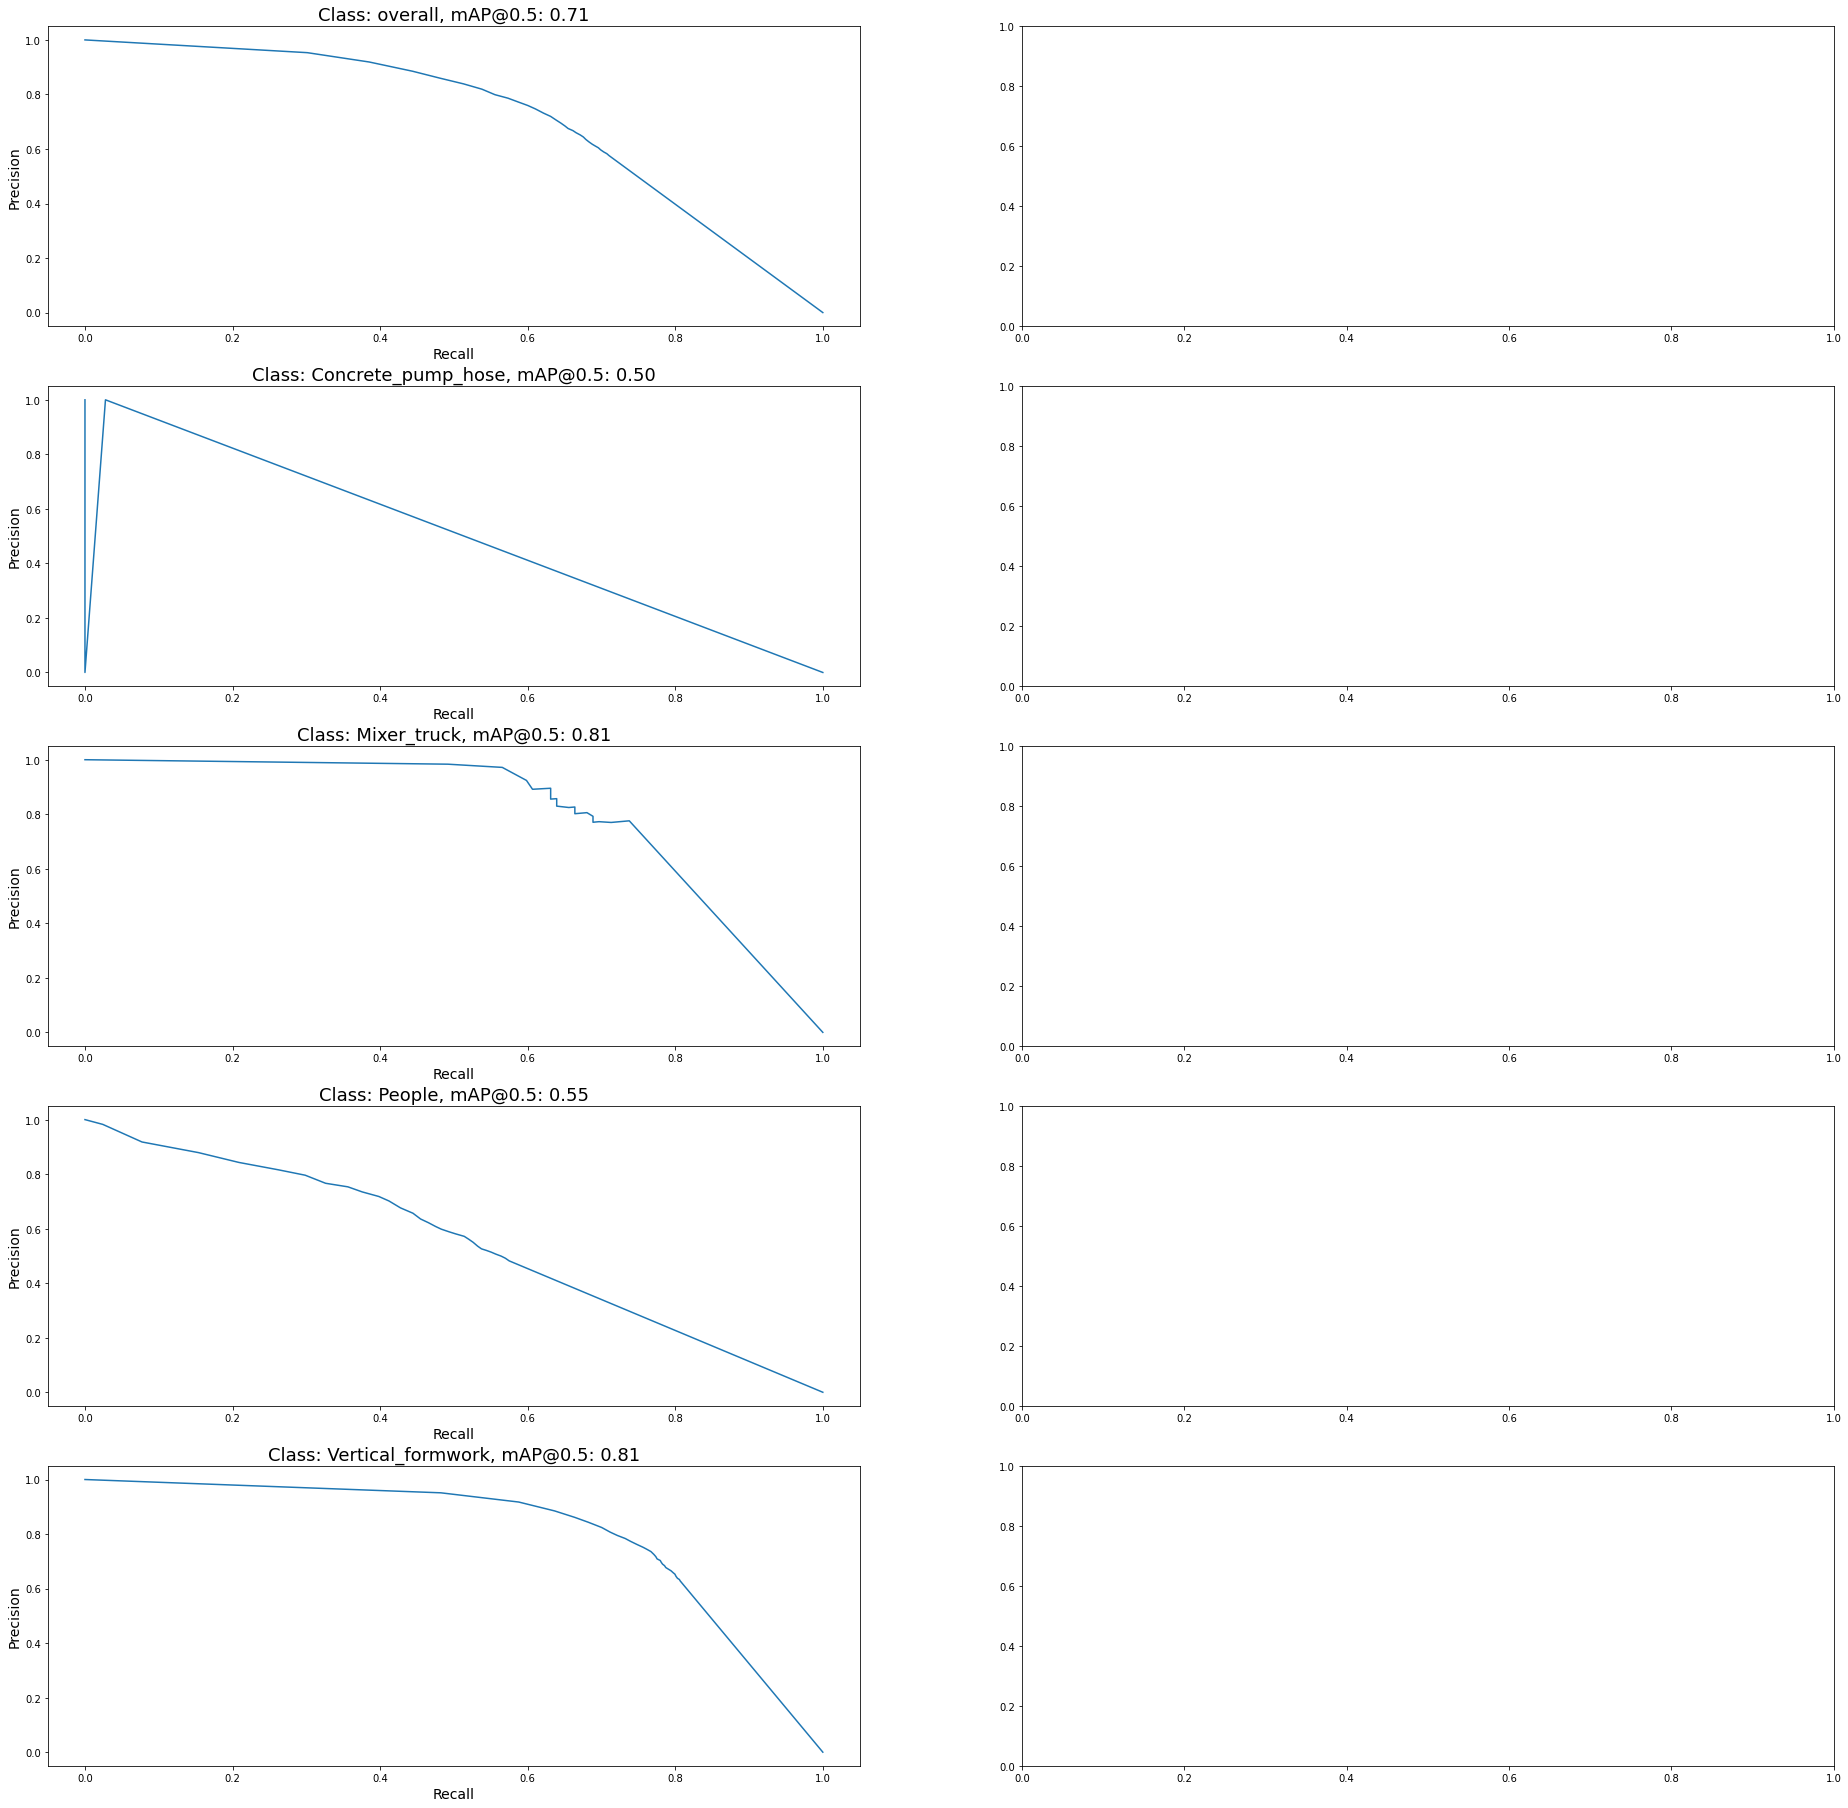

In [30]:
TOTAL_CLASSES = 5

_, axs = plt.subplots(TOTAL_CLASSES, 2, figsize=(32, 32))
mAPs = np.zeros((1, TOTAL_CLASSES))

for class_id in range(len(dataset_inference.class_names_preset)):
    if class_id == 0:
        df_class = df
        class_name = "overall"
    else:
        df_class = df[(df.pred_class == class_id) | (df.gt_class == class_id)]
        class_name = dataset_inference.class_names_preset[class_id]

    precisions, recalls = get_pr(df_class)
    mean_average_percision = get_ap(precisions, recalls)

    axs[class_id, 0].plot(recalls, precisions)
    axs[class_id, 0].set_xlabel("Recall", fontsize=14)
    axs[class_id, 0].set_ylabel("Precision", fontsize=14)
    axs[class_id, 0].set_title(f"Class: {class_name}, mAP@0.5: {mean_average_percision:.2f}",\
                               fontsize=18)

plt.savefig('PR_curves_classes.png')